# Automating stem cell count

In [1]:
# --------- Mounting Drive and Installing Packages ---------

# Are we using Colab?
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# If so, connect to Google account and install needed packages
if IN_COLAB:
    # We mount the drive
    from google.colab import drive
    drive.mount('/content/drive')
    ! ls drive/MyDrive/datasets/

    # We install the packages
    ! pip install czifile
    ! python -m pip install "napari[all]"
    ! python -m pip install -U scikit-image
    ! pip install pyclesperanto-prototype
    ! pip install lxml
    ! pip install stardist


In [2]:
# --------- Imports ---------

# General Imports
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns


# Opening Images Imports
import czifile
from pathlib import Path
from lxml import etree


# Visualizing Images Imports
import napari
from napari.utils import nbscreenshot


# Filtering Images Imports
import skimage
import skimage.draw
from skimage import morphology
from skimage import img_as_float
from skimage import exposure
from skimage import filters
from skimage.morphology import reconstruction, disk, white_tophat, square, opening
from skimage.restoration import rolling_ball, denoise_bilateral
from skimage.filters import threshold_otsu
from skimage.measure import regionprops, regionprops_table

from scipy.ndimage import gaussian_filter
from pyclesperanto_prototype import imshow


# Image Segmentation Imports
from stardist.models import StarDist2D
from skimage.segmentation import find_boundaries

# Teselation Imports
from scipy.spatial import Voronoi, voronoi_plot_2d, distance

# Clustering Imports
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture




2023-12-07 09:33:52.610381: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 09:33:52.610417: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 09:33:52.610453: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 09:33:52.620960: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
if not IN_COLAB:
  %gui qt

In [4]:
# --------- Opening Images ---------

# Instantiate a Path object
if IN_COLAB:
  czi_file_path = Path(r"drive/MyDrive/datasets/ESTA - Sph1 Z Stack - CTRL SOX2.czi")
else:
  czi_file_path = Path(r"./data/Sph4 Z Stack - CTRL SOX2.czi")

# Read the image and get the CziFile object
with czifile.CziFile(czi_file_path) as czi:
    img = czi.asarray()  # Store image data in 'img' variable
    czi_object = czi  # Store the CziFile object



In [5]:
czi.shape

(1, 1, 3, 1, 6, 2292, 2292, 1)

In [6]:
czi.axes

'BVCTZYX0'

So, according to this, `img` is an array of:
- B = 1, so one block
- V = 1, so one view
- C = 3, so three channels (which makes sense, they are the optic channel, the one indicating the nuclei and the SOX2 channel)
- T = 1, so a single time frame (i.e. no $t$ component)
- Z = 8, so 8 $z$ slices
- Y = 2292, so we have that many pixels in the $y$ direction (height)
- X = 2292, idem (note that we have a square image)
- '0' = 1, indicating that we have a single sample 


I also checked the metadata, and the spacing is the same than with Sph1.
```python
<Scaling>
      <Items>
        <Distance Id="X">
          <Value>1.2364633517553391e-007</Value>
        </Distance>
        <Distance Id="Y">
          <Value>1.2364633517553394e-007</Value>
        </Distance>
        <Distance Id="Z">
          <Value>1.9999999999999999e-006</Value>
        </Distance>
      </Items>
    </Scaling>
```

In [7]:
# --------- Getting rid of the extra dimensions ---------
image_squeezed = np.squeeze(img)
image_squeezed.shape

(3, 6, 2292, 2292)

In [8]:
# --------- Separating the channels ---------

# The first channel is the corresponding to stemness
stemness_channel = image_squeezed[0, :, :, :]
# Channel 2 is the optic one
optic_channel = image_squeezed[1, :, :, :]
# Channel 3 contains the nuclei
nuclei_channel = image_squeezed[2, :, :, :]

In [9]:
#@title Using Napari for Visualization

if not IN_COLAB:
  viewer = napari.Viewer()
  viewer.add_image(nuclei_channel, colormap='blue', blending='additive')
  viewer.add_image(stemness_channel, colormap='red', blending='additive')
  viewer.add_image(optic_channel, colormap='gray', blending='additive')
  print(viewer.layers)
  # We never close the napari window and can take a screenshot whenever we like
  nbscreenshot(viewer)

[<Image layer 'nuclei_channel' at 0x7f7cdc1fbcd0>, <Image layer 'stemness_channel' at 0x7f7d9eca7280>, <Image layer 'optic_channel' at 0x7f7cd3fdee00>]


In [11]:
# Z slice to analyze

z_slice = 2

## Stemness Channel

In [13]:
# --------- Processing the stemness channel ---------

stemness_array = np.copy(stemness_channel)

# Convert to float
stemness_floats_array = img_as_float(stemness_array)

h = 0.5

seed = stemness_floats_array - h
mask = stemness_floats_array

dilated = reconstruction(seed, mask, method='dilation')
hdome = stemness_floats_array - dilated

# Adaptive Equalization
hdome_adapteq = exposure.equalize_adapthist(hdome, clip_limit=0.03)

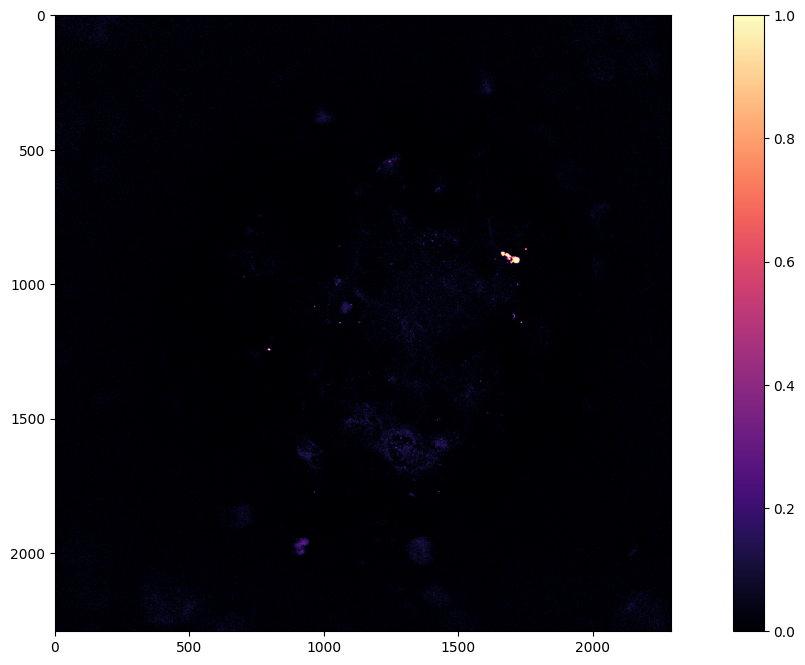

In [14]:
# --------- Visualize the result ---------

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(hdome_adapteq[z_slice], cmap='magma')
fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap='magma'), ax=ax)


# # Saving (Local)
# filename = "/slice_4/sox2_processed.png" # Local path
# plt.savefig(filename)


# # Saving (Colab)
# filename = "/content/sox2_processed.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)
# from google.colab import files
# files.download(filename)




plt.show()  # Display the plot

### Promedio de las imágenes previamente procesadas (i.e. limpias)

In [ ]:
# We define a new 2D array as the average of hdome_adapteq[1], hdome_adapteq[2], and hdome_adapteq[3]
# Increasing the precision for avoiding the loss of information
average_hdome_adapteq = (hdome_adapteq[1] + hdome_adapteq[2] + hdome_adapteq[3]) / 3.0
average_hdome_adapteq.shape

(2292, 2292)

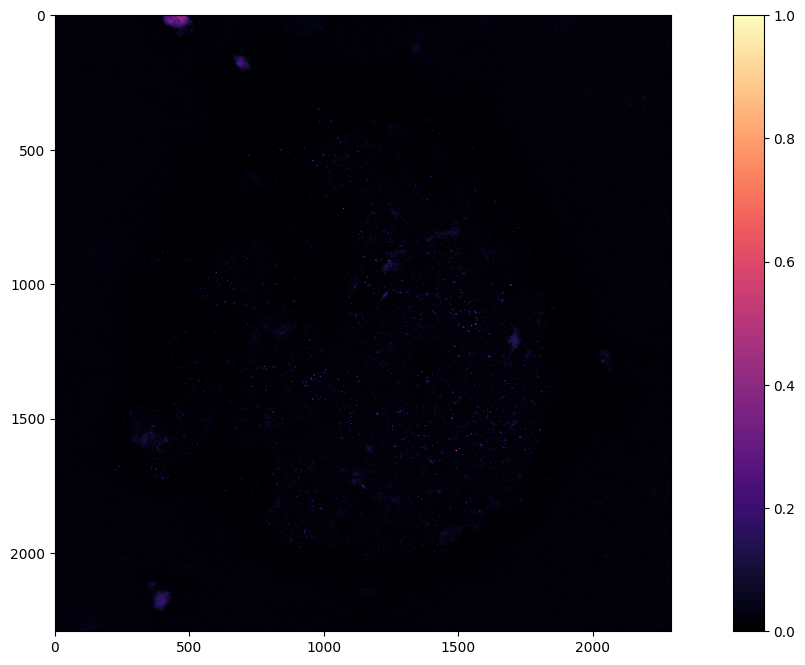

In [ ]:
# --------- Visualize the result (average of the cleaned images) ---------

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(average_hdome_adapteq, cmap='magma')
fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap='magma'), ax=ax)


# # Saving (Local)
# filename = "/slice_4/sox2_processed.png" # Local path
# plt.savefig(filename)


# # Saving (Colab)
# filename = "/content/sox2_processed.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)
# from google.colab import files
# files.download(filename)




plt.show()  # Display the plot

### Limpiamos el promedio de los cortes 1 al 3
En lo anterior, primero limpiamos y luego promediamos. Si hiciéramos al revés, el resultado sería el siguiente.

In [ ]:
# --------- Processing the stemness channel ---------

stemness_array = np.copy(stemness_channel)

# Convert to float
stemness_floats_array = img_as_float(stemness_array)

# Average of the slices 1 to 3
average_stemness_floats_array = (stemness_floats_array[1] + stemness_floats_array[2] + stemness_floats_array[3]) / 3.0

h = 0.5

seed = average_stemness_floats_array - h
mask = average_stemness_floats_array

dilated = reconstruction(seed, mask, method='dilation')
hdome = average_stemness_floats_array - dilated

# Adaptive Equalization
hdome_adapteq_of_average = exposure.equalize_adapthist(hdome, clip_limit=0.03)

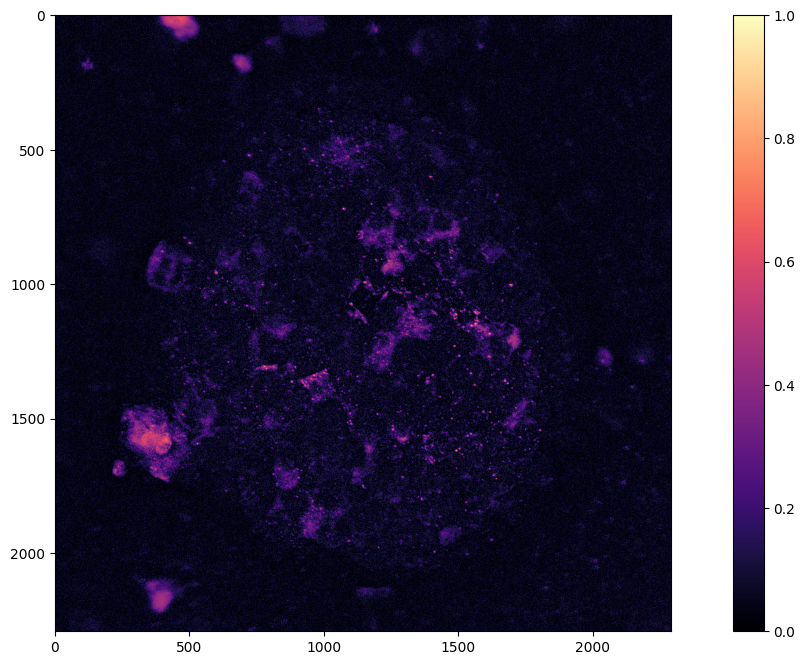

In [ ]:
# --------- Visualize the result (cleaned version of the averaged images) ---------

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(hdome_adapteq_of_average, cmap='magma')
fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap='magma'), ax=ax)


# # Saving (Local)
# filename = "/slice_4/sox2_processed.png" # Local path
# plt.savefig(filename)


# # Saving (Colab)
# filename = "/content/sox2_processed.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)
# from google.colab import files
# files.download(filename)




plt.show()  # Display the plot

## Nuclei Channel

In [15]:
# 0. Converting the original image to float (originally it's a 'uint16')
image_3d = np.copy(nuclei_channel)
image_2d = image_3d[z_slice]

image_normalized = image_3d.astype(np.float32) / 65535.0

# 1. Adaptive Histogram Equalization on the 3D image
image_3d_equalized = exposure.equalize_adapthist(image_3d)

# 2. Extract a 2D slice from the equalized 3D image
image_2d_equalized = image_3d_equalized[z_slice]

# 3. Morphological opening to remove small noise
selem = morphology.disk(2)  # using a disk-shaped structuring element of radius 2
image_2d_opened = morphology.opening(image_2d_equalized, selem)
image_2d_opened = morphology.area_closing(image_2d_opened, area_threshold=150)

# 4. Bilateral Filtering (denoising without bluring edges)
image_opened_bilateral = denoise_bilateral(image_2d_opened, sigma_color=0.05, sigma_spatial=15)

# 5. Load pretrained StarDist 2D model for fluorescent images
model = StarDist2D.from_pretrained('2D_versatile_fluo')

# Perform instance segmentation on the normalized binary image
labels, details = model.predict_instances(image_opened_bilateral)

# Extract boundaries from the labels
boundaries = find_boundaries(labels)

# ----------------------------------

# Overlay boundaries on the opened, filtered image
overlay = np.copy(image_opened_bilateral)
overlay[boundaries] = np.max(image_opened_bilateral)  # setting the boundary pixels to the maximum value of the image for visualization



Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2023-12-07 09:52:57.996079: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 679477248 exceeds 10% of free system memory.
2023-12-07 09:52:58.366165: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 679477248 exceeds 10% of free system memory.
2023-12-07 09:53:02.431440: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 339738624 exceeds 10% of free system memory.
2023-12-07 09:53:03.295347: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 679477248 exceeds 10% of free system memory.


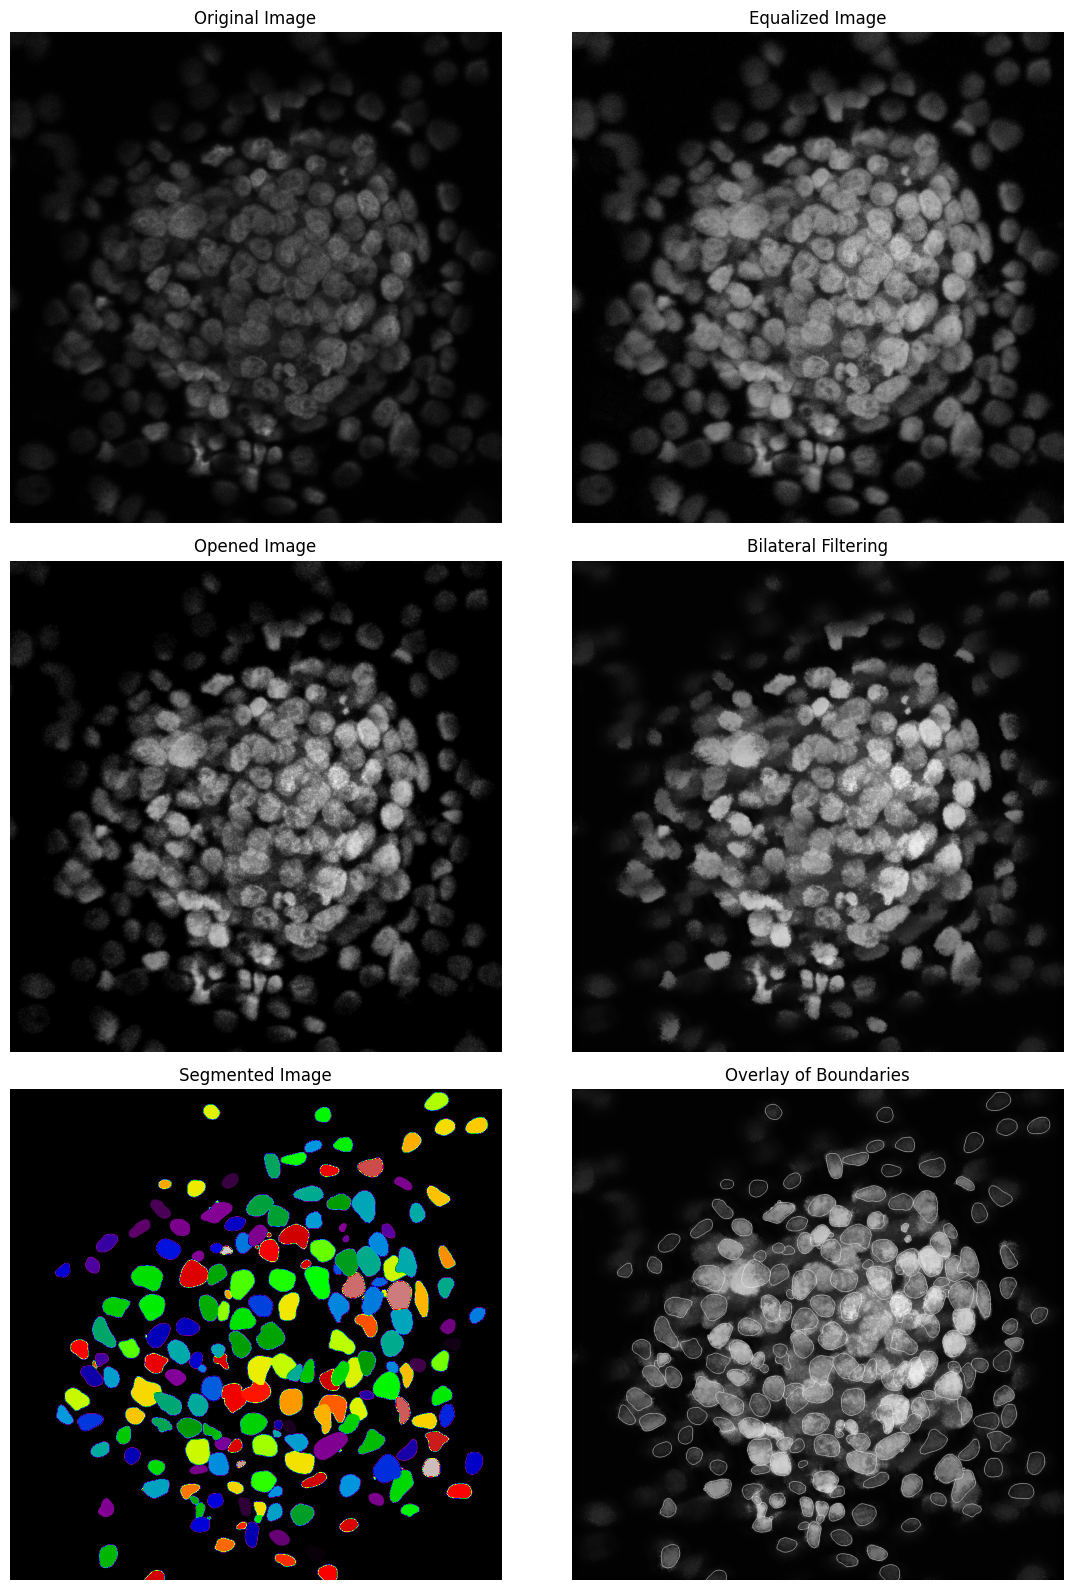

In [16]:
# --------- Visualize the result ---------


# Plotting the original, equalized, opened, and segmented images
fig, axes = plt.subplots(3, 2, figsize=(12, 16))
ax = axes.ravel()

ax[0].imshow(image_2d, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(image_2d_equalized, cmap='gray')
ax[1].set_title("Equalized Image")
ax[1].axis('off')

ax[2].imshow(image_2d_opened, cmap='gray')
ax[2].set_title("Opened Image")
ax[2].axis('off')

ax[3].imshow(image_opened_bilateral, cmap='gray')
ax[3].set_title("Bilateral Filtering")
ax[3].axis('off')

ax[4].imshow(labels, cmap='nipy_spectral')
ax[4].set_title("Segmented Image")
ax[4].axis('off')

ax[5].imshow(overlay, cmap='gray')
ax[5].set_title("Overlay of Boundaries")
ax[5].axis('off')

plt.tight_layout()


# # Saving (Local)
# filename = "/slice_4/nuclei_processing.png" # Local path
# plt.savefig(filename)


# # Saving (Colab)
# filename = "/content/sox2_processed.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)
# from google.colab import files
# files.download(filename)



plt.show()

## Generating the DataFrame

In [17]:
# --------- Generation of the DataFrame with geometrical properties of segmented objects ---------

spacing = (1.2364633517553391e-7, 1.2364633517553391e-7)  # in meters for (y, x) dimensions

properties = [
    "label", "area", "centroid", "equivalent_diameter", "bbox_area", "convex_area", "filled_area", "major_axis_length",
    "minor_axis_length", "bbox", "weighted_centroid", "coords",
    "eccentricity", "euler_number", "extent",
    "feret_diameter_max", "max_intensity", "mean_intensity", "min_intensity",
    "orientation", "perimeter", "solidity"
]

# Extract the region properties
regions = regionprops_table(labels, intensity_image=image_opened_bilateral, properties=properties) # , spacing=spacing

# Convert the result to a DataFrame
df = pd.DataFrame(regions)
df


label     area   centroid-0   centroid-1  equivalent_diameter  bbox_area  \
0        1   4959.0  2165.774753  1419.676548            79.460650     6862.0   
1        2   3900.0  1191.669231  2062.902564            70.467256     5418.0   
2        3   3017.0  1577.684123  1302.208817            61.978736     4092.0   
3        4   4383.0  1948.537303  1094.202145            74.703473     5704.0   
4        5   4271.0   432.584641  1026.352376            73.742838     5920.0   
..     ...      ...          ...          ...                  ...        ...   
199    200  12662.0   965.965092  1813.786448           126.971489    16166.0   
200    201   1030.0  1751.157282  1074.922330            36.213764     1428.0   
201    202     37.0  1771.513514  1826.837838             6.863663       48.0   
202    203   5996.0  1769.322715  1963.342895            87.374735     7221.0   
203    204   1679.0   757.463371  1008.945205            46.236016     2419.0   

     convex_area  filled_area  major_axis_length  minor_axis_length  ...  \
0         5058.0       4959.0          99.039683          64.476983  ...   
1         3989.0       3900.0          83.411319          61.912836  ...   
2         3058.0       3017.0          73.046438          52.881291  ...   
3         4495.0       4383.0          97.166314          58.268215  ...   
4         4334.0       4271.0          88.498728          61.563023  ...   
..           ...          ...                ...                ...  ...   
199      12864.0      12662.0         138.268919         117.141671  ...   
200       1062.0       1030.0          46.298093          28.749910  ...   
201         38.0         37.0           7.854193           6.084663  ...   
202       6075.0       5996.0          91.052364          84.449199  ...   
203       1788.0       1679.0          56.368441          39.832158  ...   

     eccentricity  euler_number    extent  feret_diameter_max  max_intensity  \
0        0.759059             1  0.722676           99.724621       0.308662   
1        0.670113             1  0.719823           86.700634       0.340098   
2        0.689862             1  0.737292           73.573093       0.549367   
3        0.800244             1  0.768408           97.169954       0.470357   
4        0.718393             1  0.721453           88.814413       0.166649   
..            ...           ...       ...                 ...            ...   
199      0.531271             1  0.783249          143.377125       0.501652   
200      0.783831             1  0.721289           46.957428       0.191934   
201      0.632326             1  0.770833            8.544004       0.191961   
202      0.373874             1  0.830356           94.154129       0.140913   
203      0.707574             1  0.694088           60.207973       0.250995   

     mean_intensity min_intensity  orientation   perimeter  solidity  
0          0.246941      0.018840     1.192147  275.521861  0.980427  
1          0.250435      0.031249     1.450369  244.793939  0.977689  
2          0.438122      0.151221     0.687944  206.308658  0.986593  
3          0.341877      0.038968     0.252658  262.994949  0.975083  
4          0.103536      0.017936    -0.929167  248.350288  0.985464  
..              ...           ...          ...         ...       ...  
199        0.320780      0.039437    -0.149564  430.504617  0.984297  
200        0.126584      0.064650    -1.106779  123.982756  0.969868  
201        0.110596      0.017115    -1.315866   20.485281  0.973684  
202        0.083985      0.028803    -0.212586  289.722871  0.986996  
203        0.195732      0.134705    -1.349290  163.781746  0.939038  

[204 rows x 27 columns]

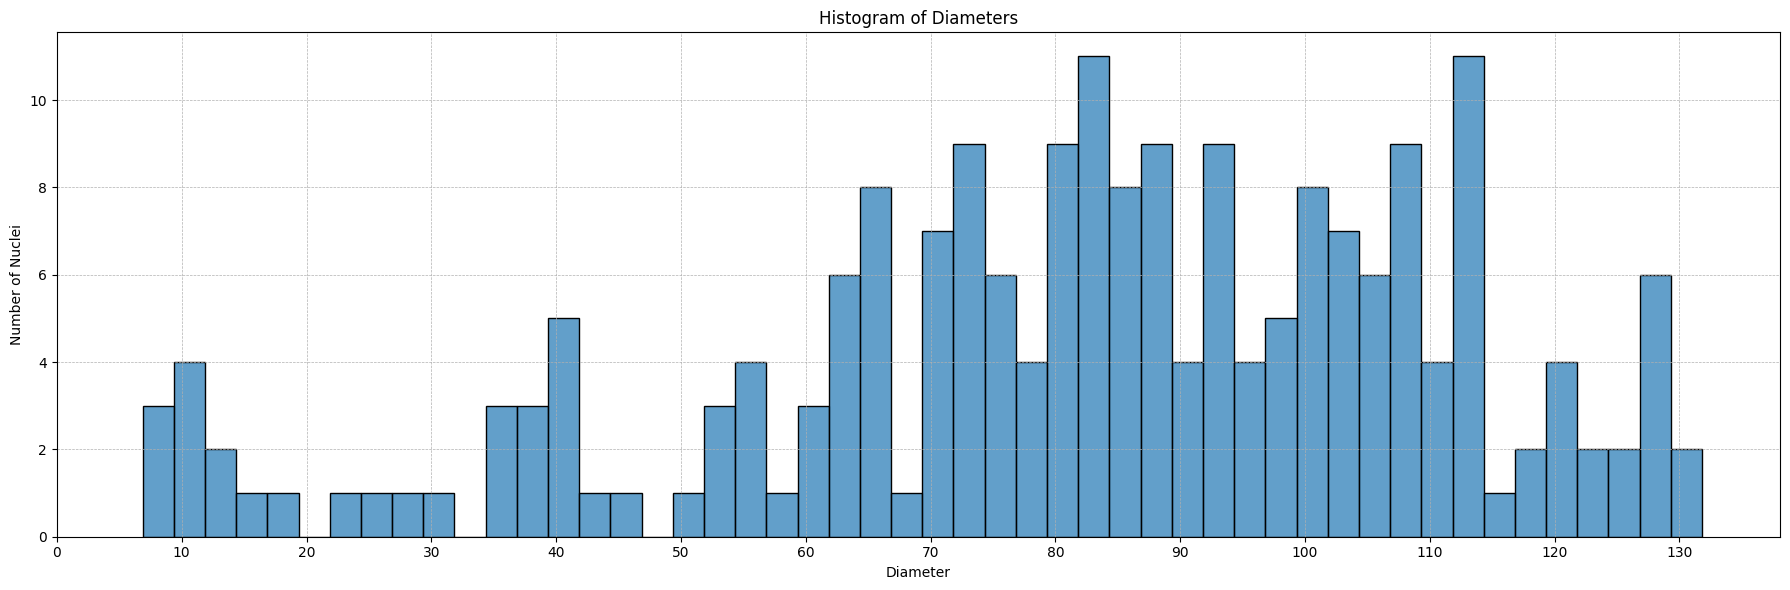

In [18]:
plt.figure(figsize=(18, 6))
sns.histplot(df, x='equivalent_diameter', bins=50, element='bars', stat='count', alpha=0.7)

# Plot customization to resemble the original plot
plt.title('Histogram of Diameters')
plt.xlabel('Diameter')
plt.ylabel('Number of Nuclei')

# Set x-ticks starting from 0 and every 10 units
xmax = plt.xlim()[1]  # Get the current maximum xlim value
plt.xticks(np.arange(0, xmax+1, 10))

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()


Podría cortar tomando sólo los objetos con diámetro > 24.

In [19]:
# --------- Voronoi Teselation ---------

# Convert centroids to integer coordinates for seeding
centroids = df[['centroid-0', 'centroid-1']].to_numpy().astype(int)

# Using the centroids as the points for Voronoi, but making sure we're using (x, y) coordinates
points = np.array([(c, r) for r, c in centroids])  # Note the coordinate reversal here
vor = Voronoi(points)


In [20]:
# --------- Counting Fluorescence Intensity in each region ---------

hdome3 = hdome[z_slice]

# Create a blank image for Voronoi segmentation
voronoi_regions = np.zeros_like(hdome3, dtype=int)

# Generate Voronoi regions
points = np.array([(c, r) for r, c in centroids])
vor = Voronoi(points)

intensity_sums = [0] * len(centroids)  # Initialize intensity sums with zeros

for region in vor.regions:
    if not -1 in region and len(region) > 0:  # Check if the region is not infinite and not empty
        polygon = [vor.vertices[i] for i in region]
        if len(polygon) > 2:  # Ensure that we have a valid polygon with more than 2 vertices
            rr, cc = skimage.draw.polygon([p[1] for p in polygon], [p[0] for p in polygon], voronoi_regions.shape)

            # Determine which centroid this region belongs to based on proximity
            region_centroid = (np.mean(rr), np.mean(cc))
            idx = np.argmin([distance.euclidean(region_centroid, cent) for cent in centroids])

            voronoi_regions[rr, cc] = idx + 1  # Add 1 to avoid using zero as a label
            intensity_sums[idx] += np.sum(hdome3[rr, cc])  # Update the intensity sum for this region

# Add the intensity sums to the dataframe
df['Fluorescence_Intensity'] = intensity_sums

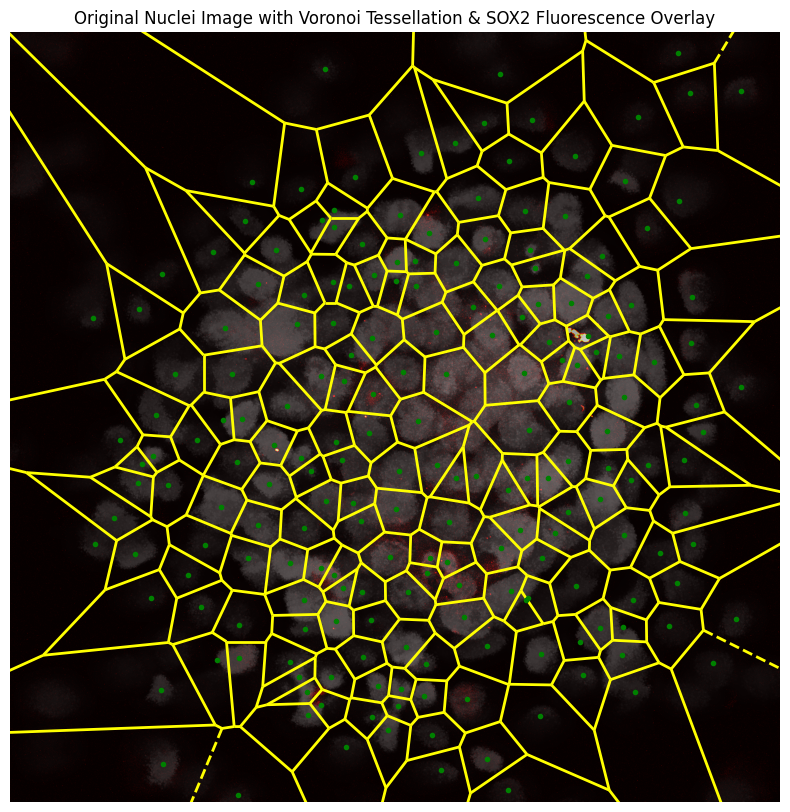

In [21]:
# --------- Regions, Nuclei and SOX2 Overlay ---------

# Using the centroids as the points for Voronoi, ensuring (x, y) coordinates
points = np.array([(c, r) for r, c in centroids])  # Coordinate reversal
vor = Voronoi(points)

# Start the plot and display the original image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_opened_bilateral, cmap='gray')

# Overlay the Voronoi diagram without the original Voronoi points
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_colors='yellow', line_width=2)

# Overlay the fluorescence channel using a colormap. Here, I assume fluorescence_image represents your fluorescence channel.
ax.imshow(hdome[z_slice], cmap='hot', alpha=0.6)  # Adjust alpha for desired transparency of overlay

# Display the centroids on top
for (r, c) in centroids:
    ax.plot(c, r, 'g.')  # Using (x, y) convention

ax.set_xlim([0, labels.shape[1]])
ax.set_ylim([labels.shape[0], 0])  # Invert y-axis to match image coordinates
ax.set_title('Original Nuclei Image with Voronoi Tessellation & SOX2 Fluorescence Overlay')
plt.axis('off')


# # Saving (Local)
# filename = "Devel/experimental_images/results/slice_4/nuclei_voronoi_sox2.png" # Local path
# plt.savefig(filename)


# # Saving (Colab)
# filename = "/content/nuclei_voronoi_sox2.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)
# from google.colab import files
# files.download(filename)



plt.show()

## Stem and Differentiated Cell Clustering

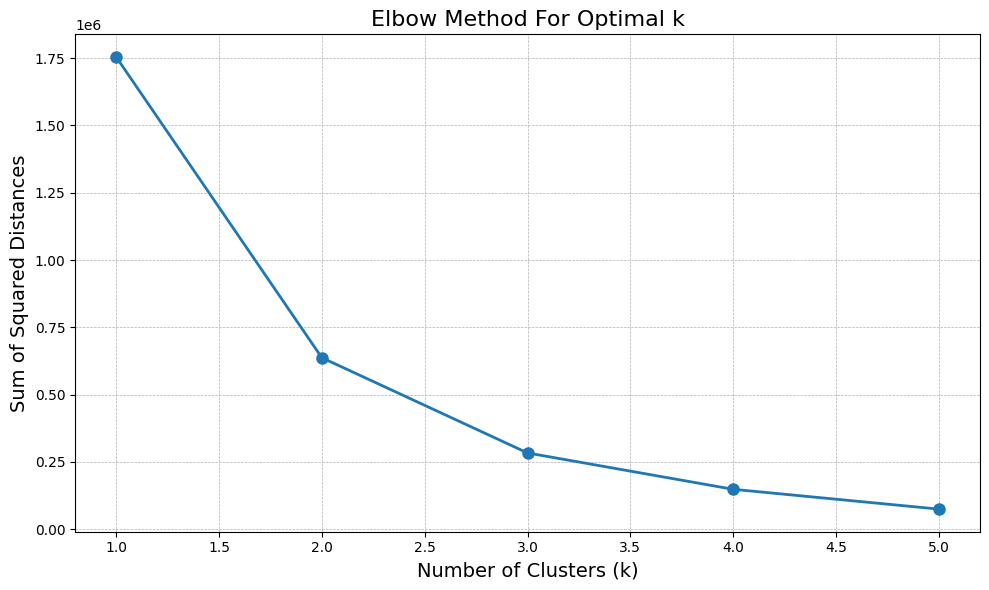

In [22]:
# --------- Elbow plot for cluster number ---------

# Extract fluorescence intensity values from the DataFrame
fluorescence_intensities = df['Fluorescence_Intensity'].values.reshape(-1, 1)

# Calculate sum of squared distances (SSD) for different values of k
ssd = []
range_n_clusters = range(1, 6)

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init='auto', random_state=42)
    kmeans.fit(fluorescence_intensities)
    ssd.append(kmeans.inertia_)

# Plot the SSD values against k to visualize the elbow
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Sum of Squared Distances', fontsize=14)
plt.title('Elbow Method For Optimal k', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [23]:
# Filter out regions with Fluorescence_Intensity <= 180
filtered_df = df[df['Fluorescence_Intensity'] <= 180].copy()  # Use copy() to ensure we're working on a copy

# Reshape the Fluorescence_Intensity data for clustering
X = filtered_df['Fluorescence_Intensity'].values.reshape(-1, 1)

# Perform GMM clustering with k=2
gmm = GaussianMixture(n_components=2)
gmm.fit(X)


# Get the clustering labels
labels = gmm.predict(X)

# Compute the mean fluorescence intensity for each cluster
cluster_means = np.array([filtered_df['Fluorescence_Intensity'][labels == i].mean() for i in np.unique(labels)])

# Identify the labels of the clusters with higher and lower mean intensities
label_higher_intensity = cluster_means.argmax()
label_lower_intensity = cluster_means.argmin()

# Replace labels to ensure cluster with higher mean intensity is labeled 1 and the other as 0
labels[labels == label_higher_intensity] = 2  # Use 2 as a temporary label to avoid confusion during replacement
labels[labels == label_lower_intensity] = 0
labels[labels == 2] = 1  # Finally replace temporary label 2 with 1

# Assign the corrected labels to the filtered dataframe
filtered_df.loc[:, 'filtered_GMM_stemness'] = labels


# Assign the corrected labels to the filtered dataframe
filtered_df.loc[:, 'filtered_GMM_stemness'] = labels

# Create a new column in the original dataframe for the mapped labels, initialized to NaN
df['filtered_GMM_stemness'] = np.nan

# Map the GMM_stemness labels back to the original df
df.update(filtered_df['filtered_GMM_stemness'])

# Set the values to 1 where Fluorescence_Intensity > 180
df.loc[df['Fluorescence_Intensity'] > 180, 'filtered_GMM_stemness'] = 1


In [24]:
df[['label', 'Fluorescence_Intensity', 'filtered_GMM_stemness']].loc[df['Fluorescence_Intensity']>85].loc[df['Fluorescence_Intensity']<95].sort_values(by='Fluorescence_Intensity')

label  Fluorescence_Intensity  filtered_GMM_stemness
72      73               85.254017                    1.0
79      80               86.889960                    1.0
189    190               89.866423                    1.0
47      48               92.518334                    1.0
145    146               94.240070                    1.0
183    184               94.653162                    1.0

In [25]:
# the number of one's is the number of CSCs
filtered_GMM_stemness_ones = df['filtered_GMM_stemness'].sum()
print(f"Number of CSCs according to filtered_GMM_stemness: {filtered_GMM_stemness_ones}")
print(f'They represent a {filtered_GMM_stemness_ones / df.shape[0] * 100:.4f}% of the total number of cells')
print('The threshold is roughly at a fluorescence intensity of 89.')

Number of CSCs according to filtered_GMM_stemness: 106.0
They represent a 51.9608% of the total number of cells
The threshold is roughly at a fluorescence intensity of 89.


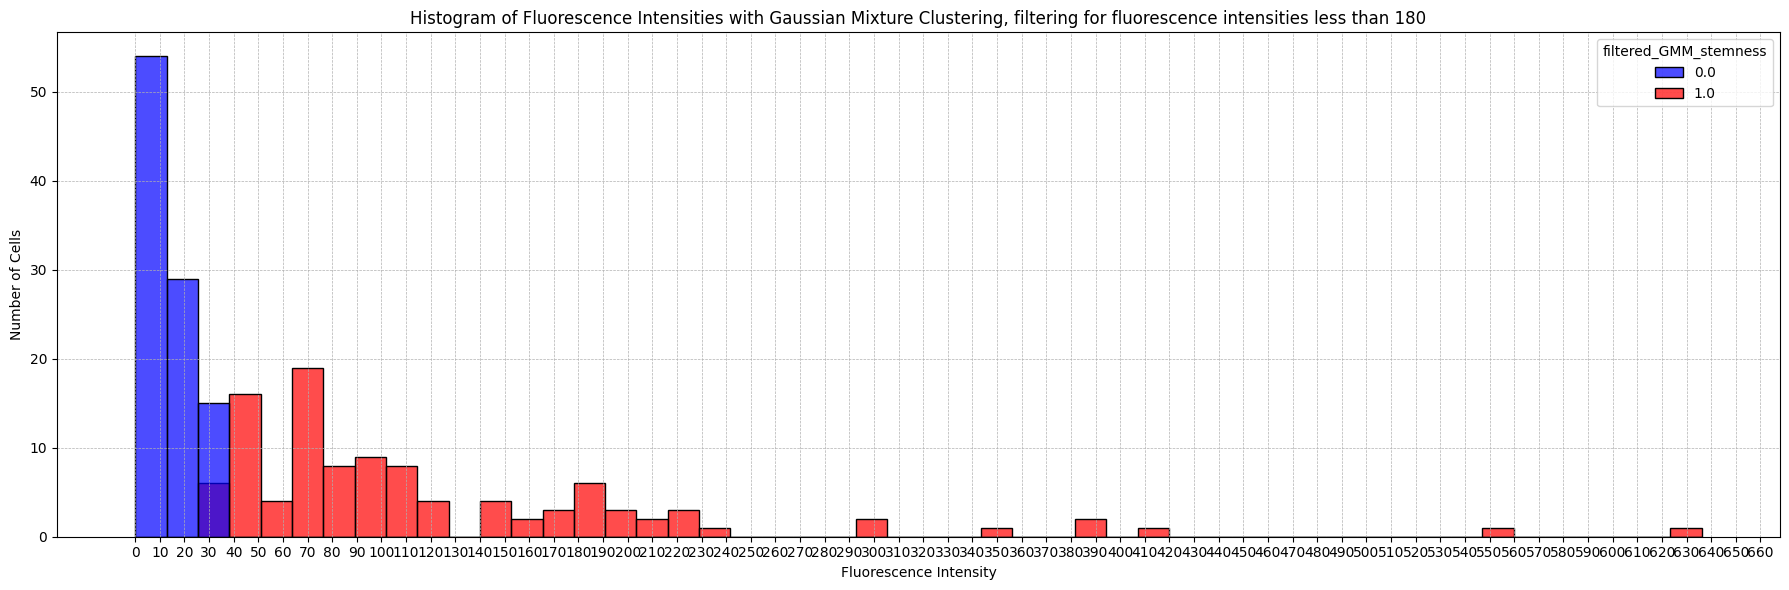

In [26]:
plt.figure(figsize=(18, 6))
sns.histplot(df, x='Fluorescence_Intensity', hue='filtered_GMM_stemness', bins=50, palette=['blue', 'red'], element='bars', stat='count', common_norm=False, alpha=0.7)

# Plot customization to resemble the original plot
plt.title('Histogram of Fluorescence Intensities with Gaussian Mixture Clustering, filtering for fluorescence intensities less than 180')
plt.xlabel('Fluorescence Intensity')
plt.ylabel('Number of Cells')

# Set x-ticks starting from 0 and every 10 units
xmax = plt.xlim()[1]  # Get the current maximum xlim value
plt.xticks(np.arange(0, xmax+1, 10))

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()



# # Save the plot to your computer
# filename = "/content/histogram_GMM-means-filtered-intensity<180_clustering.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)

# # To download the file to your local machine from Colab
# from google.colab import files
# files.download(filename)



plt.show()

In [27]:
# Save the DataFrame to a CSV

# Define the directory path
directory = f"./results/sph4/slice_{z_slice}/"
csv_file_path = os.path.join(directory, f"sph4_slice_{z_slice}.csv")

# # Save the DataFrame to a CSV in the specified directory
# df.to_csv(csv_file_path, index=False)


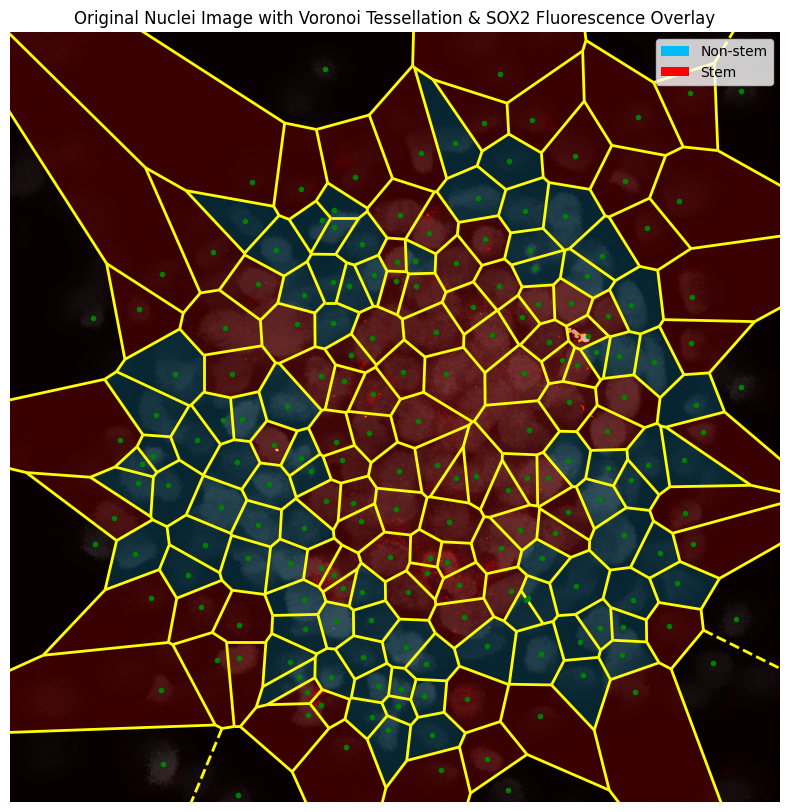

In [28]:


# Define a soft, pastel colormap
pastel_cmap = ListedColormap(['#02bbf7', '#fc0303'])  # modified colors as requested

# Using the centroids as the points for Voronoi, ensuring (x, y) coordinates
points = np.array([(c, r) for r, c in centroids])  # Coordinate reversal
vor = Voronoi(points)

# Start the plot and display the original image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_opened_bilateral, cmap='gray')

# Create an empty image to overlay the Voronoi regions
voronoi_overlay = np.zeros(image_opened_bilateral.shape + (4,), dtype=np.uint8)  # Note the 4 for RGBA

# Fill the Voronoi regions with color based on 'filtered_GMM_stemness'
for point_idx, region_idx in enumerate(vor.point_region):
    region = vor.regions[region_idx]
    if not -1 in region and len(region) > 0:  # Check if the region is not infinite and not empty
        polygon = [vor.vertices[i] for i in region]
        rr, cc = skimage.draw.polygon([p[1] for p in polygon], [p[0] for p in polygon], image_opened_bilateral.shape)

        # Get the color based on 'filtered_GMM_stemness'
        stemness_value = df.at[point_idx, 'filtered_GMM_stemness']
        color = pastel_cmap(stemness_value)

        voronoi_overlay[rr, cc] = np.array(color)*255  # Assuming 'color' is an RGBA tuple

# Display the colored Voronoi overlay
ax.imshow(voronoi_overlay, alpha=0.5)  # Adjust alpha for desired transparency

# Overlay the Voronoi diagram without the points, with yellow lines for boundaries
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_colors='yellow', line_width=2)

# Overlay the fluorescence channel using a colormap. Assume 'hdome[z_slice]' represents your fluorescence channel.
ax.imshow(hdome[z_slice], cmap='hot', alpha=0.6)  # Adjust alpha for desired transparency of overlay

# Display the centroids on top
for (r, c) in centroids:
    ax.plot(c, r, 'g.')  # green dot for each centroid

# Legend for the Voronoi region colors
legend_labels = [Patch(facecolor=pastel_cmap(0), label='Non-stem'), 
                 Patch(facecolor=pastel_cmap(1), label='Stem')]
ax.legend(handles=legend_labels, loc='upper right')

ax.set_xlim([0, image_opened_bilateral.shape[1]])
ax.set_ylim([image_opened_bilateral.shape[0], 0])  # Invert y-axis to match image coordinates
ax.set_title('Original Nuclei Image with Voronoi Tessellation & SOX2 Fluorescence Overlay')
plt.axis('off')

plt.show()


In [ ]:
!ls

# Working with the averages

## Average of cleaned images
Vamos a trabajar con el promedio de los cortes 1 a 3 previamente limpiados, y con la segmentación de los núcleos correspondiente al corte 3.

In [ ]:
# --------- Counting Fluorescence Intensity in each region ---------

hdome3_ac = average_hdome_adapteq

# Create a blank image for Voronoi segmentation
voronoi_regions = np.zeros_like(hdome3_ac, dtype=int)

# Generate Voronoi regions
points = np.array([(c, r) for r, c in centroids])
vor = Voronoi(points)

intensity_sums = [0] * len(centroids)  # Initialize intensity sums with zeros

for region in vor.regions:
    if not -1 in region and len(region) > 0:  # Check if the region is not infinite and not empty
        polygon = [vor.vertices[i] for i in region]
        if len(polygon) > 2:  # Ensure that we have a valid polygon with more than 2 vertices
            rr, cc = skimage.draw.polygon([p[1] for p in polygon], [p[0] for p in polygon], voronoi_regions.shape)

            # Determine which centroid this region belongs to based on proximity
            region_centroid = (np.mean(rr), np.mean(cc))
            idx = np.argmin([distance.euclidean(region_centroid, cent) for cent in centroids])

            voronoi_regions[rr, cc] = idx + 1  # Add 1 to avoid using zero as a label
            intensity_sums[idx] += np.sum(hdome3_ac[rr, cc])  # Update the intensity sum for this region

# Add the intensity sums to the dataframe
df['Fluorescence_Intensity_1st_cleaned_then_averaged'] = intensity_sums

In [ ]:
# --------- Regions, Nuclei and SOX2 Overlay ---------

# Using the centroids as the points for Voronoi, ensuring (x, y) coordinates
points = np.array([(c, r) for r, c in centroids])  # Coordinate reversal
vor = Voronoi(points)

# Start the plot and display the original image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_opened_bilateral, cmap='gray')

# Overlay the Voronoi diagram without the original Voronoi points
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_colors='yellow', line_width=2)

# Overlay the fluorescence channel using a colormap. Here, I assume fluorescence_image represents your fluorescence channel.
ax.imshow(average_hdome_adapteq, cmap='hot', alpha=0.6)  # Adjust alpha for desired transparency of overlay

# Display the centroids on top
for (r, c) in centroids:
    ax.plot(c, r, 'g.')  # Using (x, y) convention

ax.set_xlim([0, labels.shape[1]])
ax.set_ylim([labels.shape[0], 0])  # Invert y-axis to match image coordinates
ax.set_title('Original Nuclei Image with Voronoi Tessellation & SOX2 Fluorescence (cleaned then averaged) Overlay')
plt.axis('off')


# # Saving (Local)
# filename = "Devel/experimental_images/results/slice_4/nuclei_voronoi_sox2.png" # Local path
# plt.savefig(filename)


# # Saving (Colab)
# filename = "/content/nuclei_voronoi_sox2.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)
# from google.colab import files
# files.download(filename)



plt.show()

## Cleaned average of images